# IMPORTS

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from numba import cuda
import time

In [2]:
from numba import config
config.CUDA_ENABLE_PYNVJITLINK = 1 #Fix Collab PTX issue; source : https://github.com/googlecolab/colabtools/issues/5081

# LAB 3 COPY :

In [3]:
img = plt.imread('usth.jpg')
img = img.astype(np.uint16)
h, w, _ = img.shape
pixel_count = h * w
flat_img = img.reshape(pixel_count, 3)

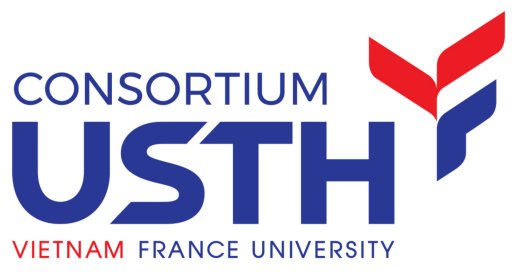

In [4]:
plt.imshow(img)
plt.axis('off')
plt.show()

In [5]:
def rgb_to_gray_cpu(src):
    for i in range(len(src)):
      g = ((src[i, 0] + src[i, 1] + src[i, 2]) / 3)
      src[i, 0] = src [i, 1] = src[i, 2] = g
    return src

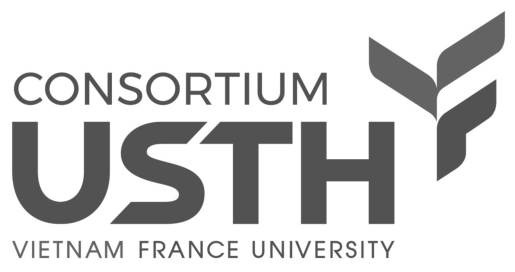

time: 1.0943677425384521


In [6]:
start_cpu = time.time()
gray_cpu = rgb_to_gray_cpu(flat_img)
end_cpu = time.time()
time_cpu = end_cpu - start_cpu

gray_cpu_img = gray_cpu.reshape((h, w,3))
plt.imshow(gray_cpu_img, cmap='gray')
plt.axis('off')
plt.show()

print("time:", time_cpu)


In [7]:
@cuda.jit
def grayscale(src, dst):
# where are we in the input?
  tidx = cuda.threadIdx.x + cuda.blockIdx.x * cuda.blockDim.x
  g = np.uint8((src[tidx, 0] + src[tidx, 1] + src[tidx, 2]) / 3)
  dst[tidx, 0] = dst[tidx, 1] = dst[tidx, 2] = g

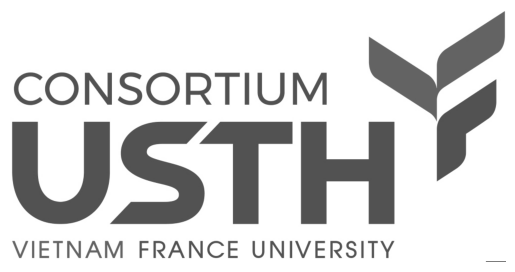

time: 1.4985947608947754


In [8]:
start_gpu = time.time()
devSrc = cuda.to_device(flat_img)
devDst = cuda.device_array((pixel_count, 3), np.uint16)
blockSize = 64
gridSize = pixel_count // blockSize
grayscale[gridSize, blockSize](devSrc, devDst)
hostDst = devDst.copy_to_host()
end_gpu = time.time()
time_gpu = end_gpu - start_gpu

gray_gpu_img = hostDst.reshape((h,w,3))
plt.imshow(gray_gpu_img)
plt.axis('off')
plt.show()

print("time:", time_gpu)


In [9]:
devSrc = cuda.to_device(flat_img)
devDst = cuda.device_array((pixel_count, 3), np.uint16)

block_sizes = [32, 64, 128, 256, 512]

for blockSize in block_sizes:
    gridSize = pixel_count // blockSize

    start_gpu = time.time()
    grayscale[gridSize, blockSize](devSrc, devDst)
    hostDst = devDst.copy_to_host()
    end_gpu = time.time()

    time_gpu = end_gpu - start_gpu
    print(blockSize, "time:", time_gpu)

32 time: 0.0009431838989257812
64 time: 0.002732515335083008
128 time: 0.0009284019470214844
256 time: 0.0009133815765380859
512 time: 0.0009050369262695312


# LAB 4

In [10]:
@cuda.jit
def grayscale_2d(src, dst, width):
    x = cuda.threadIdx.x + cuda.blockIdx.x * cuda.blockDim.x
    y = cuda.threadIdx.y + cuda.blockIdx.y * cuda.blockDim.y
    tid = y * width + x
    if x < width and tid < src.shape[0]:
        g = np.uint8((src[tid, 0] + src[tid, 1] + src[tid, 2]) / 3)
        dst[tid, 0] = dst[tid, 1] = dst[tid, 2] = g


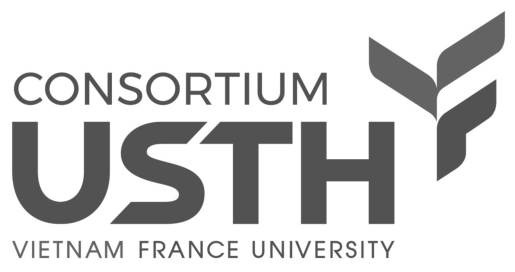

time: 0.23902344703674316


In [11]:
start_gpu = time.time()
devSrc = cuda.to_device(flat_img)
devDst = cuda.device_array((pixel_count, 3), np.uint16)

blockSize = (16, 16)
gridSize = (
    (w + blockSize[0] - 1) // blockSize[0],
    (h + blockSize[1] - 1) // blockSize[1]
)

grayscale_2d[gridSize, blockSize](devSrc, devDst, w)
hostDst = devDst.copy_to_host()

end_gpu = time.time()
time_gpu = end_gpu - start_gpu

gray_gpu_img = hostDst.reshape((h, w, 3))
plt.imshow(gray_gpu_img)
plt.axis('off')
plt.show()

print("time:", time_gpu)


In [12]:
devSrc = cuda.to_device(flat_img)
devDst = cuda.device_array((pixel_count, 3), np.uint16)

block_sizes = [(8,8), (16,16), (32,8), (8,32), (32,16), (16,32), (32,32)]

for blockSize in block_sizes:
    gridSize = (
        (w + blockSize[0] - 1) // blockSize[0],
        (h + blockSize[1] - 1) // blockSize[1]
    )

    start_gpu = time.time()
    grayscale_2d[gridSize, blockSize](devSrc, devDst, w)
    hostDst = devDst.copy_to_host()
    end_gpu = time.time()

    time_gpu = end_gpu - start_gpu
    print(blockSize, "time:", time_gpu)


(8, 8) time: 0.0010173320770263672
(16, 16) time: 0.0010302066802978516
(32, 8) time: 0.0012159347534179688
(8, 32) time: 0.0010426044464111328
(32, 16) time: 0.0010266304016113281
(16, 32) time: 0.0010120868682861328
(32, 32) time: 0.0010333061218261719
